# SmartChurn: Targeted Discounts for Customer Retention  

### Executive Summary  
Customer churn is one of the most critical challenges for energy companies, directly impacting long-term profitability.  
The **SmartChurn project** leverages machine learning to predict churn, uncover the key factors driving customer attrition, and simulate the financial impact of offering targeted discounts.  

Our analysis shows that **broad, across-the-board discounts are not profitable**.  
However, when applied **selectively to churn-prone customers**, discounts can both **improve customer retention** and deliver a **net positive profit**.  


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

### Load data

In [2]:
df = pd.read_csv('data_for_predictions.csv')

In [3]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [4]:
# Quick look at the data
print(df.shape)

(14606, 63)


In [5]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


### Data Preparation  

After careful exploratory data analysis and feature engineering, we prepare the dataset for modeling.  
We separate the target variable (**churn**) from the features, while keeping the **customer ID** for tracking.

#### Target

In [6]:
y = df['churn'].values

#### Features

In [7]:
X = df.drop(columns=['churn', 'id'])

In [8]:
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Features shape: (14606, 61), Target shape: (14606,)


And the final dataset contains **61 predictive features** across more than **14,000 customers**.  
This provides a solid foundation for training our model.

### Model: Random Forest  

We trained a **Random Forest Classifier** with **5-fold stratified cross-validation**.  
This helps evaluate the model’s reliability across different subsets of data.  

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

# Initialization
pred_train_labels = np.zeros(shape=(X.shape[0], 2))
feature_importance_df = pd.DataFrame({
    'feature_name': X.columns,
    'feature_importance': [0]*len(X.columns)})

# Stratified K-Fold CV
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)
fold_counter = 1

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Build model
    rf = RandomForestClassifier(random_state=56)
    # Train model
    rf.fit(X_train, y_train)
    # Predict
    pred_train_labels[test_index] = rf.predict_proba(X_test)
   # Accumulate feature importance
    feature_importance_df['feature_importance'] += rf.feature_importances_

    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} "
          f"Recall {recall_score(y_test, rf.predict(X_test)):.3f} "
          f"Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter += 1

# Overall metrics
pred_y = pred_train_labels.argmax(axis=1)
print("\nOverall Metrics")
print(f"Total  Precision {precision_score(y, pred_y):.3f} "
      f"Recall {recall_score(y, pred_y):.3f} "
      f"Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.739 Recall 0.060 Accuracy 0.907
Fold 2 Precision 0.871 Recall 0.095 Accuracy 0.911
Fold 3 Precision 0.875 Recall 0.074 Accuracy 0.909
Fold 4 Precision 0.818 Recall 0.063 Accuracy 0.908
Fold 5 Precision 0.762 Recall 0.057 Accuracy 0.907

Overall Metrics
Total  Precision 0.818 Recall 0.070 Accuracy 0.908


In [10]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y, pred_y))


Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     13187
           1       0.82      0.07      0.13      1419

    accuracy                           0.91     14606
   macro avg       0.86      0.53      0.54     14606
weighted avg       0.90      0.91      0.87     14606



**Results:**  
- Accuracy: ~91%  
- Precision (Churners): ~82%  
- Recall (Churners): ~7%  

The model performs very well in predicting customers who stay,  
but it struggles to detect actual churners — a classic **class imbalance problem**.  

#### Feature Importance  

To interpret the model, we analyze **feature importance scores** accumulated during training.   

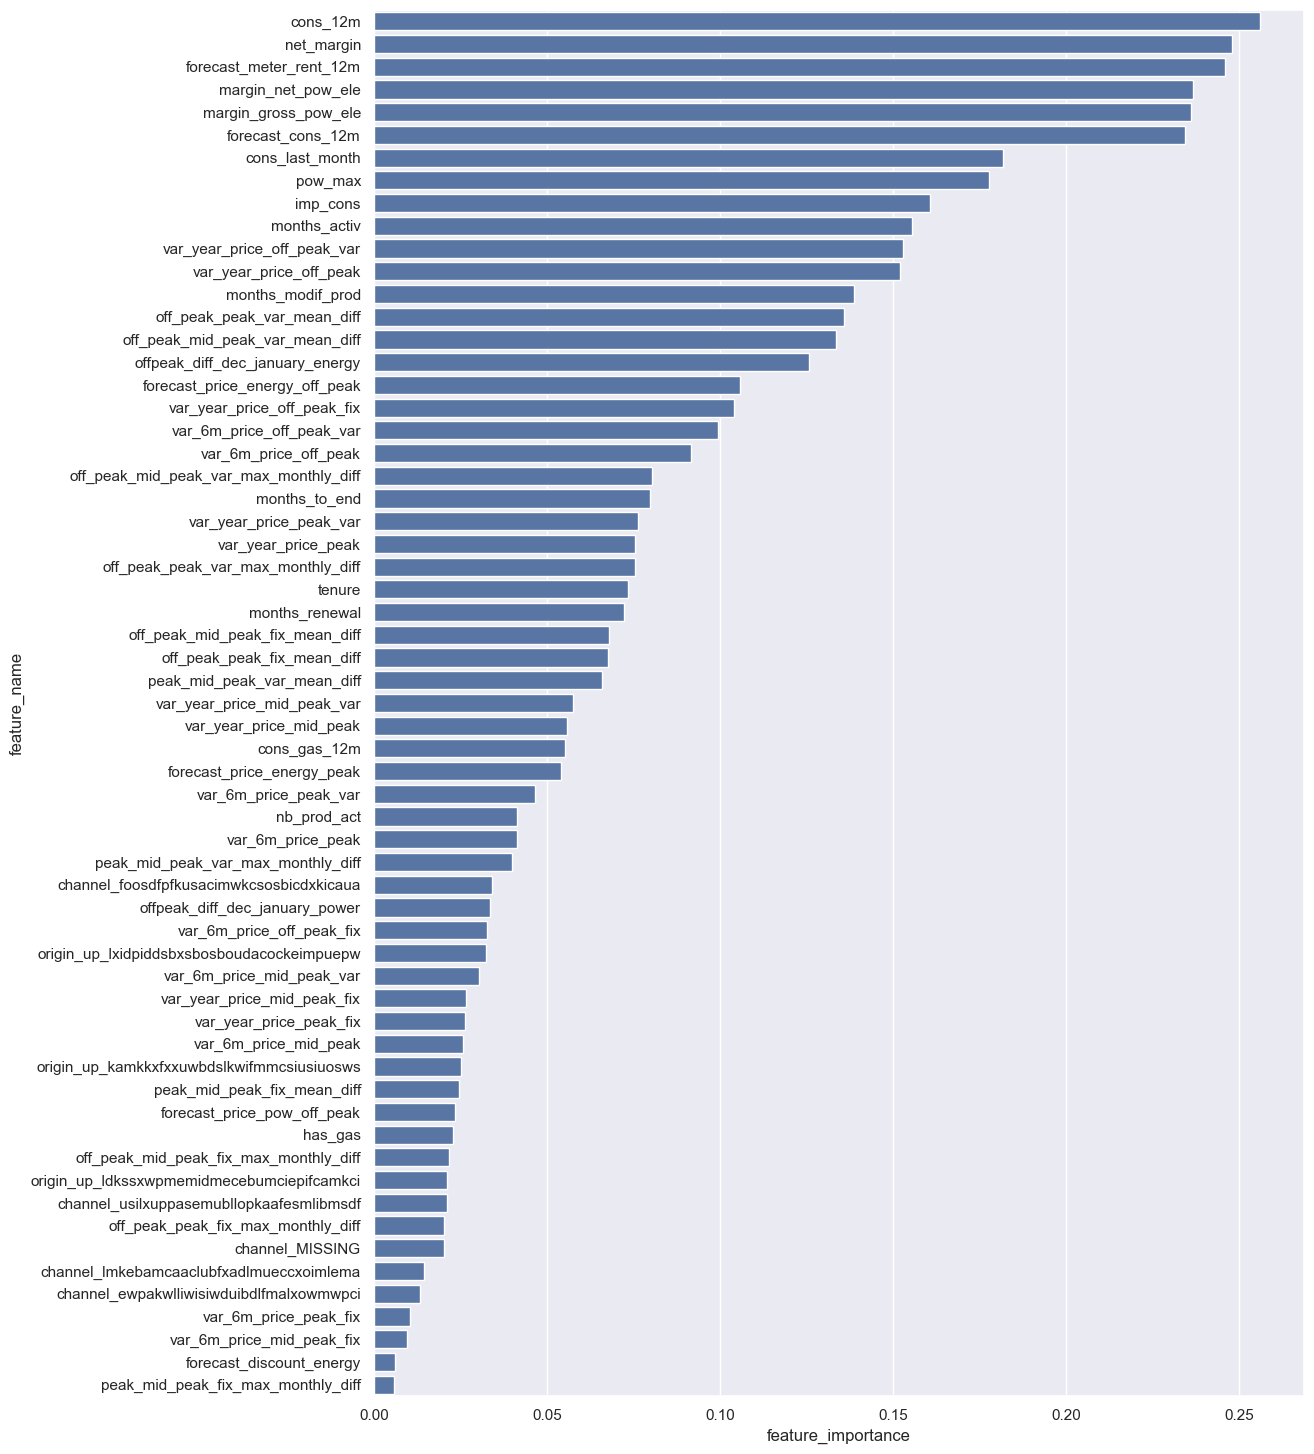

In [11]:
plt.figure(figsize=(12,18))
sns.barplot(data=feature_importance_df.sort_values(by='feature_importance', ascending=False),
            y='feature_name', x='feature_importance')
plt.show()

**Key Drivers Identified:**  
- Contract duration  
- Modification history  
- Pricing-related features  

These features align with business intuition:  
customers with shorter contracts, frequent changes, or price sensitivity are more likely to churn.  

#### Confusion Matrix  

Finally, we evaluate prediction distribution across classes with a **confusion matrix**.

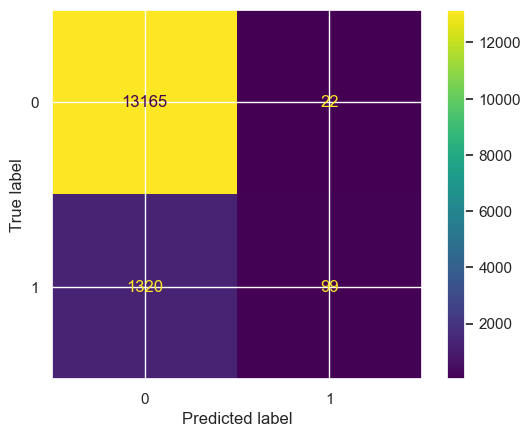

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, pred_y, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

The confusion matrix highlights the model’s strengths and limitations:

- **Non-churners (Class 0):** Predicted almost perfectly, with recall close to 100%.
- **Churners (Class 1):** Many are missed, with recall only around 7%.

This imbalance is typical in churn prediction tasks — the model is excellent at identifying customers who will stay, but it struggles to capture those at risk of leaving.
From a business standpoint, this creates a **critical risk: losing valuable customers without detecting them early.**


### 20% Discount Simulation  

**Business Question:**  
Can offering a 20% discount reduce churn while still maintaining profitability?  

To answer this, we simulated two scenarios for every customer:  

- **No Discount** – baseline churn probabilities and profits.  
- **20% Discount** – all energy-related prices reduced by 20%, with churn probabilities re-estimated by the model.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode 'has_gas'
has_gas_encoder = LabelEncoder()
X['has_gas'] = has_gas_encoder.fit_transform(X['has_gas'])

In [14]:
# List of price columns for discount simulation
price_attr = [
    'var_year_price_off_peak_var','var_year_price_peak_var','var_year_price_mid_peak_var',
    'var_year_price_off_peak_fix','var_year_price_peak_fix','var_year_price_mid_peak_fix',
    'var_6m_price_off_peak_var','var_6m_price_peak_var','var_6m_price_mid_peak_var',
    'var_6m_price_off_peak_fix','var_6m_price_peak_fix','var_6m_price_mid_peak_fix']

In [15]:
# Stratified 5-fold CV for undiscounted probabilities
pred_test_labels = np.zeros(shape=(X.shape[0], 2))
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)

fold_counter = 1
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf = RandomForestClassifier(random_state=56)
    rf.fit(X_train, y_train)

    pred_test_labels[test_index] = rf.predict_proba(X_test)

    print(f"Fold {fold_counter} Precision {precision_score(y_test, rf.predict(X_test)):.3f} "
          f"Recall {recall_score(y_test, rf.predict(X_test)):.3f} "
          f"Accuracy {accuracy_score(y_test, rf.predict(X_test)):.3f}")
    fold_counter += 1

pred_y = pred_test_labels.argmax(axis=-1)
print(f"Total  Precision {precision_score(y, pred_y):.3f} Recall {recall_score(y, pred_y):.3f} Accuracy {accuracy_score(y, pred_y):.3f}")

Fold 1 Precision 0.739 Recall 0.060 Accuracy 0.907
Fold 2 Precision 0.871 Recall 0.095 Accuracy 0.911
Fold 3 Precision 0.875 Recall 0.074 Accuracy 0.909
Fold 4 Precision 0.818 Recall 0.063 Accuracy 0.908
Fold 5 Precision 0.762 Recall 0.057 Accuracy 0.907
Total  Precision 0.818 Recall 0.070 Accuracy 0.908


In [16]:
# Fit final model with all data
rf_full = RandomForestClassifier(random_state=56)
rf_full.fit(X, y)

RandomForestClassifier(random_state=56)

In [17]:
# Probability without discount
prob_no_discount = pd.DataFrame({
    'id': df['id'],
    '0': pred_test_labels[:,0], # probability of staying
    '1': pred_test_labels[:,1] # probability of churn
})

# Probability with discount (simulating a 20% lower price)
X_discount = X.copy()
for attr in price_attr:
    X_discount[attr] = X_discount[attr] * 0.8

pred_test_labels_dis = rf_full.predict_proba(X_discount)

prob_discount = pd.DataFrame({
    'id': df['id'],
    '0_dis': pred_test_labels_dis[:,0],  # probability of staying (discount)
    '1_dis': pred_test_labels_dis[:,1]   # prob churn (discount)
})

# Combine probability results
customer_prob = prob_no_discount.merge(prob_discount, on='id')
customer_prob.head()

,id,0,1,0_dis,1_dis
0,24011ae4ebbe3035111d65fa7c15bc57,0.78,0.22,0.25,0.75
1,d29c2c54acc38ff3c0614d0a653813dd,0.93,0.07,0.92,0.08
2,764c75f661154dac3a6c254cd082ea7d,0.91,0.09,0.97,0.03
3,bba03439a292a1e166f80264c16191cb,0.99,0.01,0.99,0.01
4,149d57cf92fc41cf94415803a877cb4b,1.00,0.00,0.97,0.03


#### Expected Profit

For each customer, we calculate **expected profit** under two scenarios: with and without discount.

**General formula:**

$$
\text{Expected Profit} = P(\text{Stay}) \times \text{Customer Profit}
$$

**Specifically:**

$$
\text{Expected Profit}_{\text{No Discount}} 
= P(\text{Stay}_{\text{No Dis}}) \times \text{Profit}_{\text{No Dis}}
$$  

$$
\text{Expected Profit}_{\text{Discount}} 
= P(\text{Stay}_{\text{Dis}}) \times \text{Profit}_{\text{Dis}}
$$  

$$
\Delta \text{Profit} 
= \text{Expected Profit}_{\text{Discount}} - \text{Expected Profit}_{\text{No Discount}}
$$

This framework allows us to **quantify the financial impact of discounts** on each customer, guiding smarter retention policies.

In [18]:
# Expected profit calculation
expected_no_dis, expected_dis = [], []

for idx, row in df.iterrows():
    cid = row['id']
    
    # Profit Without Discount
    profit_no_dis = row['cons_12m']*row['var_year_price_off_peak_var'] + row['cons_gas_12m']*row['var_year_price_off_peak_fix']
    prob_stay = customer_prob.loc[customer_prob['id']==cid,'0'].values[0]
    expected_no_dis.append(prob_stay * profit_no_dis)

    # Profit With 20% Discount
    profit_dis = row['cons_12m']*row['var_year_price_off_peak_var']*0.8 + row['cons_gas_12m']*row['var_year_price_off_peak_fix']*0.8
    prob_stay_dis = customer_prob.loc[customer_prob['id']==cid,'0_dis'].values[0]
    expected_dis.append(prob_stay_dis * profit_dis)

# Assign to DataFrame
customer_prob['expected_no_dis'] = expected_no_dis
customer_prob['expected_dis'] = expected_dis
# Difference between discounted and non-discounted expected profit
customer_prob['diff_discount'] = customer_prob['expected_dis'] - customer_prob['expected_no_dis']

In [19]:
customer_prob.head()

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
0,24011ae4ebbe3035111d65fa7c15bc57,0.78,0.22,0.25,0.75,4.077167,1.045428,-3.031740
1,d29c2c54acc38ff3c0614d0a653813dd,0.93,0.07,0.92,0.08,0.000017,0.000013,-0.000003
2,764c75f661154dac3a6c254cd082ea7d,0.91,0.09,0.97,0.03,0.000014,0.000012,-0.000002
3,bba03439a292a1e166f80264c16191cb,0.99,0.01,0.99,0.01,0.000017,0.000014,-0.000003
4,149d57cf92fc41cf94415803a877cb4b,1.00,0.00,0.97,0.03,0.000054,0.000042,-0.000012


In [20]:
customer_prob[customer_prob['diff_discount']>0].head()

,id,0,1,0_dis,1_dis,expected_no_dis,expected_dis,diff_discount
74,38ff1f75487719c54ba3d4a46f9ee244,0.69,0.31,0.91,0.09,0.000044,0.000047,2.450294e-06
79,cfc1377e09c9866fae771bb4180f026a,0.73,0.27,0.94,0.06,0.000021,0.000022,6.331773e-07
121,987a0a5e856d2185db60c718da435160,0.66,0.34,0.90,0.10,0.028594,0.031193,2.599434e-03
128,3c4ee938001975a4d07cf27a54de433c,0.57,0.43,0.83,0.17,0.000069,0.000080,1.130254e-05
166,2dc2ed2f6f850a665167d36502131713,0.66,0.34,0.92,0.08,0.000032,0.000035,3.629277e-06


In [21]:
print("2% of customers benefit from discount:", customer_prob[customer_prob['diff_discount']>0].shape[0]/len(customer_prob))

2% of customers benefit from discount: 0.03211009174311927


In [22]:
print("Number of predicted churners:", customer_prob[customer_prob['1']>0.5].shape[0])

Number of predicted churners: 121


In [23]:
print("Number of churners with profit increase:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']>0)].shape[0])


Number of churners with profit increase: 58


In [24]:
print("Number of churners with profit decrease:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']<=0)].shape[0])

Number of churners with profit decrease: 63


In [25]:
print("Total extra profit from churners with increase:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']>0)]['diff_discount'].sum())

Total extra profit from churners with increase: 21.790118169898026


In [26]:
print("Total extra profit from churners with decrease:", customer_prob[(customer_prob['1']>0.5)&(customer_prob['diff_discount']<=0)]['diff_discount'].sum())

Total extra profit from churners with decrease: -0.05456127828472009


In [27]:
print("Total extra profit from all predicted churners:", customer_prob[customer_prob['1']>0.5]['diff_discount'].sum())

Total extra profit from all predicted churners: 21.73555689161331


**Results:**

- Only **3% of customers**  generate higher profit under the discount scenario.
- Among predicted churners:
  - **58 customers** see profit increase **(+21.7 units in total)**.
  - **63 customers** see profit decrease **(−0.05 units in total)**.
- **Net effect:** a small but **positive overall gain**, concentrated in a limited customer segment.

Some customers even show **negative ΔProfit**, meaning discounts reduce revenue without significantly lowering churn risk.

This reinforces the need for a **targeted discount strategy**:

- Apply discounts only to churn-prone customers where the retention gain outweighs revenue loss.
- Avoid giving discounts to customers who would stay anyway or whose churn probability does not improve.

#### Visual Analysis of Discount Effects
To better understand how discounts affect churn probability and profitability,
we generate three complementary visualizations.

##### Churn Probability

We compare churn probability before and after applying a 20% discount.

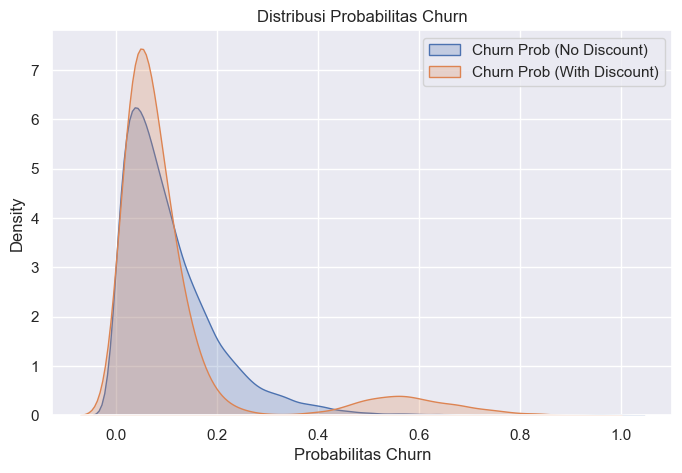

In [28]:
plt.figure(figsize=(8,5))
sns.kdeplot(customer_prob['1'], label='Churn Prob (No Discount)', shade=True)
sns.kdeplot(customer_prob['1_dis'], label='Churn Prob (With Discount)', shade=True)
plt.title("Distribusi Probabilitas Churn")
plt.xlabel("Probabilitas Churn")
plt.ylabel("Density")
plt.legend()
plt.show()

With discounts, churn probability **shifts slightly downward**, but not uniformly.
This means discounts help reduce churn for some customers, but for others the effect is negligible.  

##### Expected Profit Comparison

Next, we evaluate expected profit for each customer under both scenarios.

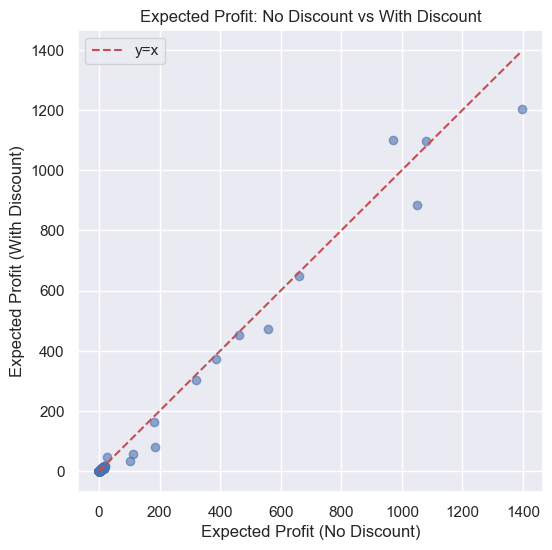

In [29]:
plt.figure(figsize=(6,6))
plt.scatter(customer_prob['expected_no_dis'], customer_prob['expected_dis'], alpha=0.6)
plt.plot([customer_prob['expected_no_dis'].min(), customer_prob['expected_no_dis'].max()],
         [customer_prob['expected_no_dis'].min(), customer_prob['expected_no_dis'].max()],
         'r--', label="y=x")
plt.title("Expected Profit: No Discount vs With Discount")
plt.xlabel("Expected Profit (No Discount)")
plt.ylabel("Expected Profit (With Discount)")
plt.legend()
plt.show()

Most customers cluster **along the diagonal**, meaning discounts don’t change profitability.
But importantly, a subset of **churn-prone customers move above the line**, meaning they generate **higher profit under the discount scenario**. This validates the selective benefit of offering discounts only to the right customers.

##### Customer Segmentation

Finally, we identify which customers are most suitable for targeted discounts.

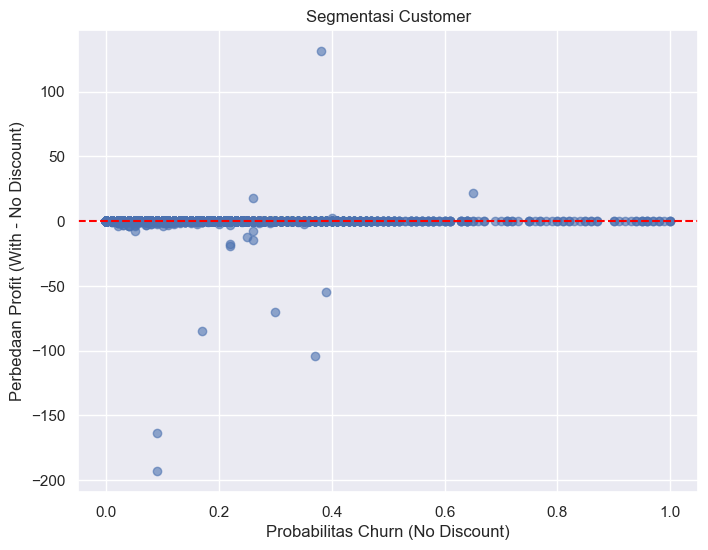

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(customer_prob['1'], customer_prob['diff_discount'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Segmentasi Customer")
plt.xlabel("Probabilitas Churn (No Discount)")
plt.ylabel("Perbedaan Profit (With - No Discount)")
plt.show()

- Customers in the **top-right quadrant** (high churn probability + positive ΔProfit) are **ideal discount targets**.
- Customers **below the red line** should not receive discounts → as it reduces profit.
- This segmentation gives a clear strategy: **focus retention discounts only where they drive net gain**.

### Final Recommendation

Across-the-board discounts are ineffective — they reduce overall profit while barely improving churn.

With SmartChurn, discounts can be transformed into a **strategic retention lever**:

- Apply 20% discounts **only to customers with high churn probability and positive ΔProfit**.
- **Avoid offering discounts** to customers who are low-risk or unlikely to yield profit gains.

By targeting discounts this way, the company can **maximize retention impact while protecting profitability**, ensuring resources are spent where they deliver the greatest business value.